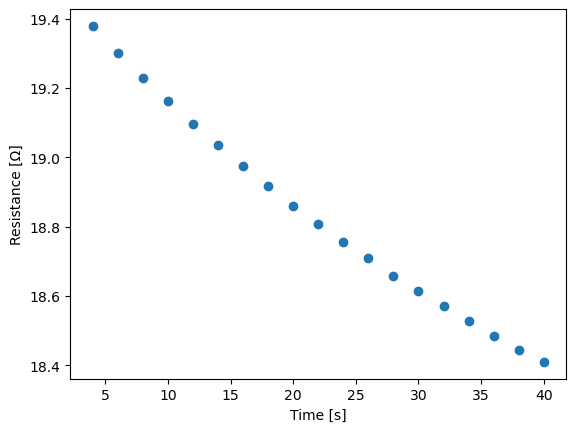

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "Dados/data.csv"
df = pd.read_csv(file_path)

plt.scatter(df['Time'], df['Resistance'])
plt.xlabel('Time [s]')
plt.ylabel('Resistance [Ω]')
plt.show()

## Estimação por ODR da resistência no instante 0

In [13]:
import numpy as np
from scipy import odr

####### Replicando o artigo de referência #######

# Incertezas de medição:

s_t0 = 0.1 # Incerteza do tempo inicial

s_dt = 0.001 # Incerteza do tempo de aquisição

s_dR = 0.001 # Incerteza da medição de resistência

# Modelo da função
def estimation_model(params, x):
    return params[1] * x + params[0]

# Prepara dados
x = df['Time'].values
y = df['Resistance'].values

# Passa incerteza para x e y
s_x = np.sqrt(s_t0**2 + s_dt**2)
s_y = s_dR

# Define o modelo
model = odr.Model(estimation_model)

# Create objeto RealData
data = odr.RealData(x, y, sx = s_x, sy = s_y)

# Seta parâmetro iniciais
initial_params = [1.0, 1.0]

# ODR fit
odr_fit = odr.ODR(data, model, beta0=initial_params)
result = odr_fit.run()

# Fitted parameters
intercept, slope = result.beta

# Desvio padrão dos parâmetros estimados
uncertainty = result.sd_beta

print("Uncertainty:", uncertainty)
print("Slope:", slope)
print("Intercept:", intercept)

R2 = intercept
s_R2 = uncertainty[1]

Uncertainty: [0.01530851 0.00062333]
Slope: -0.026861854973040413
Intercept: 19.430013622916988


## Conversão da resistência para temperatura

In [12]:
R1 = 15.39 # Resistência no início do teste
Tamb_1 = 24 # Temperatura ambiente no início do teste
Tamb_2 = 24 # Temperatura ambiente no início do teste

k = 234.5 # Recíproco do coeficiente de temperatura do resistor
alpha = 1/(k+Tamb_1) # Coeficiente de temperatura do resistor

s_R1 = 0.01 # Incerteza da medição de resistência no início do teste
s_Tamb1 = 0.1 # Incerteza da medição de temperatura no início do teste
s_Tamb2 = 0.1 # Incerteza da medição de temperatura no final do teste


# Usando equação do artigo IEEE LATAM

# Cálculo da variação de temperatura 
dT1 = (R2-R1)/(R1*alpha)

s_dT1 = [1*s_Tamb1, # Incerteza da temperatura ambiente
         -R2/(alpha*(R1**2))*s_R1, # Incerteza da resistência inicial
         1/(alpha*R1)*s_R2] # Incerteza da resistência final

s_dT1 = np.linalg.norm(s_dT1) # Incerteza combinada é a raiz da soma dos quadrados

print("IEEE LATAM")
print("Temperature rise [K]:", dT1)
print("Uncertainty [K]:", s_dT1)
print('\n')

# Usando equação do artigo do Int J Thermophys, com correção
# na ordem de R1 e R2

# Cálculo da variação de temperatura
dT2 = (R2-R1)/R1*(k+Tamb_1)-(Tamb_2-Tamb_1)

s_dT2 = [((R2-R1)/R1 + 1)*s_Tamb1, # Incerteza da temperatura ambiente inicial
         -1*s_Tamb2, # Incerteza da temperatura ambiente final
         -R2*(k+Tamb_1)/(R1**2)*s_R1, # Incerteza da resistência inicial
         (k+Tamb_1)/R1*s_R2] # Incerteza da resistência final

s_dT2 = np.linalg.norm(s_dT2) # Incerteza combinada é a raiz da soma dos quadrados

print("Int J Thermophys")
print("Temperature rise [K]:", dT2)
print("Uncertainty [K]:", s_dT2)

IEEE LATAM
Temperature rise [K]: 67.85857839662386
Uncertainty [K]: 0.2346882517385413


Int J Thermophys
Temperature rise [K]: 67.85857839662386
Uncertainty [K]: 0.26649177368197396
